In [178]:
pacotes <- c("janitor", "tidyverse", "tidymodels", "vroom", "corrr", "GGally", "rpart.plot")
instalados <- installed.packages()
for(pacote in pacotes) {
  if (!(pacote %in% instalados)) install.packages(pacote)
}

library(tidyverse)
library(tidymodels)
library(janitor)
library(vroom)
library(corrr)
library(GGally)
library(rpart.plot)

Loading required package: rpart

Attaching package: ‘rpart’

The following object is masked from ‘package:dials’:

    prune



Warning message:
package ‘rpart.plot’ was built under R version 4.5.2 


Note que as 32 colunas são inferidas como do tipo `ch` (*string* em outras linguagem). Podemos observar alguns dados ausentes (representados por `N/A`) e uma mistura entre pontos e vírgulas como separadores decimais (em linguagens de programação, comumente usamos pontos como separador).

Também temos um *warning* (aviso) dizemos que há um eror de *parsing*. Trata-se de um problema na estrutura do arquivo, usaremos a função `problems()` para entender melhor.

In [14]:
dados <- vroom::vroom(
  "./wbcd_dirty.csv"
)
dados

Rows: 566 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): diagnosis, perimeter_mean, area_mean, smoothness_mean, compactness...
dbl (24): ID, radius mean, radius SE, radius worst, texture mean, texture SE...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 


# A tibble: 566 × 32
         ID diagnosis `radius mean` `radius SE` `radius worst` `texture mean`
      <dbl> <chr>             <dbl>       <dbl>          <dbl>          <dbl>
 1   842302 M                  18.0        10.4          123.           1001 
 2   842517 M                  20.6        17.8          133.           1326 
 3 84458202 M                  13.7        20.8           90.2           578.
 4   844981 m                  13          21.8           87.5           520.
 5 84501001 M                  12.5        24.0           84.0           476.
 6   845636 M                  16.0        23.2          103.            798.
 7 84610002 M                  15.8        17.9          104.            781 
 8   846226 M                  19.2        24.8          132.           1123 
 9   846381 M                  15.8        24.0          104.            783.
10 84667401 m                  13.7        22.6           93.6           578.
# ℹ 556 more rows
# ℹ 26 more variables: `t

A saída da função nos diz que na terceira linha do arquivo, deveriamos ter 32 colunas, mas foram encontradas 51 (?!). Primeiro tentaremos tratar esse problema.

In [15]:
dados %>% vroom::problems()

# A tibble: 3 × 5
    row   col expected   actual           file                                  
  <int> <int> <chr>      <chr>            <chr>                                 
1     3    31 a double   "1932\""         C:/Users/idris/Sources/SEMAC/wbcd_dir…
2     3    32 a double   "0.3063,0.08368" C:/Users/idris/Sources/SEMAC/wbcd_dir…
3     3    33 32 columns "33 columns"     C:/Users/idris/Sources/SEMAC/wbcd_dir…

Importamos o arquivo enquanto texto usando a função `readLines()`, aqui a variáveis `linha` é apenas uma lista de strings e não um `dataframe`. Da saída de `problems()`, sabemos que o problema está na linha 3. Usamos a função `cat()` para ver o conteúdo da linha. Não use `print()` aqui, o motivo fica como exercício.

In [16]:
linhas <- readr::read_lines("./wbcd_dirty.csv")
linhas[3]

[1] "842517,\"M\",20.57,17.77,132.9,1326,0.08474,0.07864,\"0.0869\",0.07017,0.1812,\"0.05667\",0.5435,0.7339,\"3.398\",74.08,0.005225,\"0.01308\",0.0186,0.0134,\"0.01389\",0.003532,24.99,\"23.41\",158.8,1956,0.1238,0.1866,0.2416,\"0.186,0.275,0.08902"

Usamos a função `str_split` para quebrar a linha em *tokens* separados por vírgula (qual o problema em fazer isso? Exercício!) e salvamos na variáves `tokens`.

Após isso, usaremos uma expressão regular (famoso *RegEx*), linguagem que busca padrões textuais, para identificar a falha. Não faz parte do nosso curso aprender a escrever expressões regulares, mas elas são extremamente úteis e é bom *saber* que elas existem (talvez seja um curso legal pra pedir no futuro!).

A função `map` (similar à família `apply`) permite executar uma função sobre todos os elementos de uma lista, vetor ou matriz. Aqui testamos a expressão regular em todos os *tokens* e, então, vemos quais tokens são problemáticos.

O *token* problemático é `"\"0.186"`, basta notar a sequência de escape `\"` indicando aspas desbalanceadas.

In [17]:
tokens <- stringr::str_split(linhas[3], ',')
tokens %>%
  purrr::map(grep, pattern = '(?:(?!").(,|$))+', perl = TRUE) %>%
  purrr::map(~tokens[[1]][.])

[[1]]
 [1] "842517"   "20.57"    "17.77"    "132.9"    "1326"     "0.08474" 
 [7] "0.07864"  "0.07017"  "0.1812"   "0.5435"   "0.7339"   "74.08"   
[13] "0.005225" "0.0186"   "0.0134"   "0.003532" "24.99"    "158.8"   
[19] "1956"     "0.1238"   "0.1866"   "0.2416"   "\"0.186"  "0.275"   
[25] "0.08902" 


Utilizamos a função `str_replace` para corrigir a falha identificada, *i.e.*, fechar a aspa. Após isso, usamos a função `write_lines` para salvar o arquivo corrigido.

In [18]:
linhas[3] <- stringr::str_replace(linhas[3], '("\\d+\\.\\d+),(\\d+\\.\\d+)', '\\1",\\2')
readr::write_lines(linhas, "./wbcd_01.csv")

Agora, importamos o arquivo corrigido como um `dataframe` com a função `vroom`. Também aplicaremos algumas modificações dado os problemas que percebemos anteriormente.

Perceba que após a modificação, várias colunas foram determinadas como do tipo `dbl` (*double*, números ponto flutuante de precisão dupla), enquanto claramente numéricas ainda se mantém como `chr`.

In [19]:
dados <- vroom::vroom(
  "./wbcd_01.csv",
  # na = "N/A",                       # NÃO USAR!
  locale = locale(decimal_mark = ".") # usa . como separador decimal
)

dados %>% pillar::glimpse()

Rows: 571 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): diagnosis, perimeter_mean, area_mean, smoothness_mean, compactness...
dbl (24): ID, radius mean, radius SE, radius worst, texture mean, texture SE...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 571
Columns: 32
$ ID                   <dbl> 842302, 842517, 84300903, 84348301, 84358402, 843…
$ diagnosis            <chr> "M", "M", "M", "M", "M", "M", "M", "M", "m", "M",…
$ `radius mean`        <dbl> 17.990, 20.570, 19.690, 11.420, 20.290, 12.450, 1…
$ `radius SE`          <dbl> 10.38, 17.77, 21.25, 20.38, 14.34, 15.70, 19.98, …
$ `radius worst`       <dbl> 122.80, 132.90, 130.00, 77.58, 135.10, 82.57, 119…
$ `texture mean`       <dbl> 1001.0, 1326.0, 1203.0, 386.1, 1297.0, 477.1, 104…
$ `texture SE`         <dbl> 0.11840, 0.08474, 0.10960, 0.14250, 

Inicialmente, notem que as colunas possuem nomes inconsistentes, com espaços e caixa alta.

In [20]:
names(dados)

 [1] "ID"                   "diagnosis"            "radius mean"         
 [4] "radius SE"            "radius worst"         "texture mean"        
 [7] "texture SE"           "texture worst"        "perimeter_mean"      
[10] "perimeter_SE"         "perimeter_worst"      "area_mean"           
[13] "area_SE"              "area_worst"           "smoothness_mean"     
[16] "smoothness_SE"        "smoothness_worst"     "compactness_mean"    
[19] "compactness_SE"       "compactness_worst"    "Concavity_mean"      
[22] "Concavity_SE"         "Concavity_worst"      "concave_points_mean" 
[25] "concave_points_SE"    "concave_points_worst" "Symmetry mean"       
[28] "Symmetry SE"          "Symmetry worst"       "fractal_dim_mean"    
[31] "fractal_dim_SE"       "fractal_dim_worst"   

Usaremos a função `clean_names` que automaticamente estrutura os nomes em um formato pré-definido.

In [21]:
dados <- janitor::clean_names(dados)
names(dados)

 [1] "id"                   "diagnosis"            "radius_mean"         
 [4] "radius_se"            "radius_worst"         "texture_mean"        
 [7] "texture_se"           "texture_worst"        "perimeter_mean"      
[10] "perimeter_se"         "perimeter_worst"      "area_mean"           
[13] "area_se"              "area_worst"           "smoothness_mean"     
[16] "smoothness_se"        "smoothness_worst"     "compactness_mean"    
[19] "compactness_se"       "compactness_worst"    "concavity_mean"      
[22] "concavity_se"         "concavity_worst"      "concave_points_mean" 
[25] "concave_points_se"    "concave_points_worst" "symmetry_mean"       
[28] "symmetry_se"          "symmetry_worst"       "fractal_dim_mean"    
[31] "fractal_dim_se"       "fractal_dim_worst"   

Lidaremos agora com as observações com "N/A". Estes são dados faltantes. O R possui um tipo próprio para representar dados faltantes, o `NA`. Alguns usuários já habituados com funções como `vroom` e `read_csv` podem estar tentados a importar os dados com o parâmetro `na = "N/A"`, mas isso causará grandes problemas relacionados a coerção de tipos.

Faremos a transformação usando uma função que usarão bastante: `mutate`, um dos *verbos do dialeto *TidyVerse* da linguagem R. Aqui, operaremos sobre (`across`) todas as colunas onde (`where`) o tipo é `chr` (`is_character`), então usamos a função `na_if` para substituir por NA uma observação caso esta seja "N/A".

A lógica de linguagem é bastante natural: Realizaremos uma mutação (`mutate`), essa mutação exige um *onde* e um *quando*.

In [22]:
dados <- dados %>% mutate(across(where(is_character), ~na_if(., "N/A")))
dados %>% pillar::glimpse()

Rows: 571
Columns: 32
$ id                   <dbl> 842302, 842517, 84300903, 84348301, 84358402, 843…
$ diagnosis            <chr> "M", "M", "M", "M", "M", "M", "M", "M", "m", "M",…
$ radius_mean          <dbl> 17.990, 20.570, 19.690, 11.420, 20.290, 12.450, 1…
$ radius_se            <dbl> 10.38, 17.77, 21.25, 20.38, 14.34, 15.70, 19.98, …
$ radius_worst         <dbl> 122.80, 132.90, 130.00, 77.58, 135.10, 82.57, 119…
$ texture_mean         <dbl> 1001.0, 1326.0, 1203.0, 386.1, 1297.0, 477.1, 104…
$ texture_se           <dbl> 0.11840, 0.08474, 0.10960, 0.14250, 0.10030, 0.12…
$ texture_worst        <dbl> 0.27760, 0.07864, 0.15990, 0.28390, 0.13280, 0.17…
$ perimeter_mean       <chr> "0.3001", "0.0869", "0.1974", "0.2414", "0.198", …
$ perimeter_se         <dbl> 0.14710, 0.07017, 0.12790, 0.10520, 0.10430, 0.08…
$ perimeter_worst      <dbl> 0.2419, 0.1812, 0.2069, 0.2597, 0.1809, 0.2087, 0…
$ area_mean            <chr> "0.07871", "0.05667", "0.05999", NA, "0.05883", "…
$ area_se         

Em seguida, tentaremos lidar com os erros de separador decimal. Também usaremos `mutate` e `across` e `where`.

Aqui a regra de decisão é: opere *onde* (`where`) a coluna for do tipo for `chr`, exceto `ID`e `diagnosis` (por que?). A função `parse_number` transforma uma `string` em um tipo numérico cabível.

In [23]:
dados <- dados %>%
  mutate(
    across(
      where(is.character) & !c(id, diagnosis), # regra de decisão, where = onde
      ~ parse_number(
        str_replace_all(.x, ",", "."),         # substitui "," por "."
      )
    )
  )

dados %>% pillar::glimpse()

Rows: 571
Columns: 32
$ id                   <dbl> 842302, 842517, 84300903, 84348301, 84358402, 843…
$ diagnosis            <chr> "M", "M", "M", "M", "M", "M", "M", "M", "m", "M",…
$ radius_mean          <dbl> 17.990, 20.570, 19.690, 11.420, 20.290, 12.450, 1…
$ radius_se            <dbl> 10.38, 17.77, 21.25, 20.38, 14.34, 15.70, 19.98, …
$ radius_worst         <dbl> 122.80, 132.90, 130.00, 77.58, 135.10, 82.57, 119…
$ texture_mean         <dbl> 1001.0, 1326.0, 1203.0, 386.1, 1297.0, 477.1, 104…
$ texture_se           <dbl> 0.11840, 0.08474, 0.10960, 0.14250, 0.10030, 0.12…
$ texture_worst        <dbl> 0.27760, 0.07864, 0.15990, 0.28390, 0.13280, 0.17…
$ perimeter_mean       <dbl> 0.30010, 0.08690, 0.19740, 0.24140, 0.19800, 0.15…
$ perimeter_se         <dbl> 0.14710, 0.07017, 0.12790, 0.10520, 0.10430, 0.08…
$ perimeter_worst      <dbl> 0.2419, 0.1812, 0.2069, 0.2597, 0.1809, 0.2087, 0…
$ area_mean            <dbl> 0.07871, 0.05667, 0.05999, NA, 0.05883, 0.07613, …
$ area_se         

Agora buscaremos por observações (linhas) duplicadas. Temos uma linha repetida duas vezes. Observações repetidas afetam a variabildade dos dados. Corrigimos usando a função `distinct`.

In [24]:
janitor::get_dupes(dados)

No variable names specified - using all columns.



# A tibble: 4 × 33
      id diagnosis radius_mean radius_se radius_worst texture_mean texture_se
   <dbl> <chr>           <dbl>     <dbl>        <dbl>        <dbl>      <dbl>
1 925291 B                11.5      23.9         74.5         404.     0.0926
2 925291 B                11.5      23.9         74.5         404.     0.0926
3 926125 M                20.9      25.1        143          1347      0.110 
4 926125 M                20.9      25.1        143          1347      0.110 
# ℹ 26 more variables: texture_worst <dbl>, perimeter_mean <dbl>,
#   perimeter_se <dbl>, perimeter_worst <dbl>, area_mean <dbl>, area_se <dbl>,
#   area_worst <dbl>, smoothness_mean <dbl>, smoothness_se <dbl>,
#   smoothness_worst <dbl>, compactness_mean <dbl>, compactness_se <dbl>,
#   compactness_worst <dbl>, concavity_mean <dbl>, concavity_se <dbl>,
#   concavity_worst <dbl>, concave_points_mean <dbl>, concave_points_se <dbl>,
#   concave_points_worst <dbl>, symmetry_mean <dbl>, symmetry_se <dbl>, …

In [25]:
dados <- dados %>% dplyr::distinct()
janitor::get_dupes(dados)

No variable names specified - using all columns.

No duplicate combinations found of: id, diagnosis, radius_mean, radius_se, radius_worst, texture_mean, texture_se, texture_worst, perimeter_mean, ... and 23 other variables


# A tibble: 0 × 33
# ℹ 33 variables: id <dbl>, diagnosis <chr>, radius_mean <dbl>,
#   radius_se <dbl>, radius_worst <dbl>, texture_mean <dbl>, texture_se <dbl>,
#   texture_worst <dbl>, perimeter_mean <dbl>, perimeter_se <dbl>,
#   perimeter_worst <dbl>, area_mean <dbl>, area_se <dbl>, area_worst <dbl>,
#   smoothness_mean <dbl>, smoothness_se <dbl>, smoothness_worst <dbl>,
#   compactness_mean <dbl>, compactness_se <dbl>, compactness_worst <dbl>,
#   concavity_mean <dbl>, concavity_se <dbl>, concavity_worst <dbl>, …

Agora, podemos usar a função `summary` (sumário) para exibir algumas medidas descritivas. Aqui selecionamos (`select`) as colunas que terminam com (`ends_with`) `_mean` (média).

In [26]:
dados %>%
  select(ends_with("_mean")) %>%
  summary()

  radius_mean      texture_mean    perimeter_mean      area_mean      
 Min.   : 6.981   Min.   : 143.5   Min.   :0.00000   Min.   :0.04996  
 1st Qu.:11.700   1st Qu.: 420.3   1st Qu.:0.02956   1st Qu.:0.05766  
 Median :13.370   Median : 551.1   Median :0.06126   Median :0.06147  
 Mean   :14.127   Mean   : 654.9   Mean   :0.08893   Mean   :0.06265  
 3rd Qu.:15.780   3rd Qu.: 782.7   3rd Qu.:0.13070   3rd Qu.:0.06608  
 Max.   :28.110   Max.   :2501.0   Max.   :0.42680   Max.   :0.09575  
                                   NA's   :28        NA's   :28       
 smoothness_mean  compactness_mean   concavity_mean     concave_points_mean
 Min.   : 0.757   Min.   :0.002252   Min.   :0.007882   Min.   :12.02      
 1st Qu.: 1.606   1st Qu.:0.013310   1st Qu.:0.015020   1st Qu.:21.06      
 Median : 2.312   Median :0.020730   Median :0.018720   Median :25.41      
 Mean   : 2.902   Mean   :0.025484   Mean   :0.020551   Mean   :25.69      
 3rd Qu.: 3.398   3rd Qu.:0.032140   3rd Qu.:0.02349

Um problema não tão óbvio é que há uma grande bagunça na coluna `diagnosis`. Queremos `M` para malígno e `B` para benígno, mas note que temos 5 valores diferentes vivendo no conjunto.

In [27]:
str_unique(dados$diagnosis)

[1] "M"      "m"      "B"      "Benign" "b"     

Usaremos mais uma vez `mutate` para corrigir o problema juntamente da função `case_when` (caso ..., então). Se `diagnonsis` é parte do vetor `c("M", "m")` (ou seja, igual a um dos elementos), então substitua por `"M"`. Se `diagnonsis` é parte do vetor `c("B", "b", "Benign)`, então substitua por `"B"`.

In [165]:
dados <- dados %>%
  mutate(
    diagnosis = case_when(
      diagnosis %in% c("M", "m") ~ "M",
      diagnosis %in% c("B", "b", "Benign") ~ "B"
    ),
    diagnosis = forcats::as_factor(diagnosis)
  )

unique(dados$diagnosis)

[1] M B
Levels: M B

O próximo problema que tratamos é o de dados faltantes, os `NA`. Uma solução muito comum é a de remover as linhas com observações faltantes, essa prática pode inviabilizar a aplicação de técnicas estatísticas, além de desperdiçar as observações existentes na linha.

Aplicaremos um procedimento básico de imputação de dados: a imputação por mediana.

In [166]:
dados %>%
  group_by(diagnosis) %>%
  mutate(across(where(is.numeric), ~replace_na(.x, median(.x, na.rm = TRUE)))) %>%
  ungroup()

# A tibble: 569 × 32
         id diagnosis radius_mean radius_se radius_worst texture_mean texture_se
      <dbl> <fct>           <dbl>     <dbl>        <dbl>        <dbl>      <dbl>
 1   842302 M                18.0      10.4        123.         1001      0.118 
 2   842517 M                20.6      17.8        133.         1326      0.0847
 3 84300903 M                19.7      21.2        130          1203      0.110 
 4 84348301 M                11.4      20.4         77.6         386.     0.142 
 5 84358402 M                20.3      14.3        135.         1297      0.100 
 6   843786 M                12.4      15.7         82.6         477.     0.128 
 7   844359 M                18.2      20.0        120.         1040      0.0946
 8 84458202 M                13.7      20.8         90.2         578.     0.119 
 9   844981 M                13        21.8         87.5         520.     0.127 
10 84501001 M                12.5      24.0         84.0         476.     0.119 
# ℹ 559

Warning message:
Removed 28 rows containing non-finite outside the scale range (`stat_bin()`). 


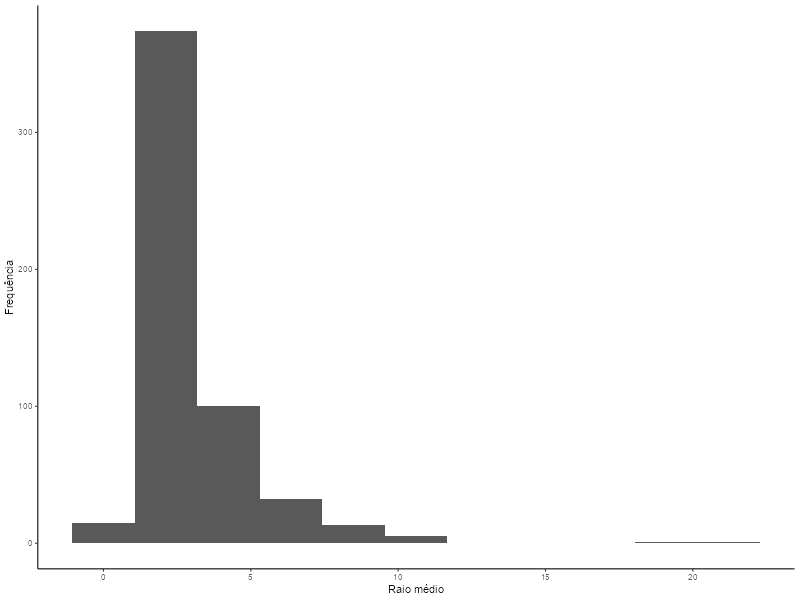

In [59]:
dados %>%
  ggplot(aes(x = smoothness_mean)) +
  geom_histogram(bins = nclass.Sturges(dados$radius_mean)) +
  labs(
    x = "Raio médio",
    y = "Frequência"
  ) +
  theme_classic()

In [167]:
dados_longos <- dados %>%
  # primeiro sem, depois com `matches()`
  tidyr::pivot_longer(cols = c(matches("_(mean|se|worst)")), cols_vary = "slowest",
  names_to = "variavel", values_to = "valor"
)
dados_longos

# A tibble: 17,070 × 4
         id diagnosis variavel    valor
      <dbl> <fct>     <chr>       <dbl>
 1   842302 M         radius_mean  18.0
 2   842517 M         radius_mean  20.6
 3 84300903 M         radius_mean  19.7
 4 84348301 M         radius_mean  11.4
 5 84358402 M         radius_mean  20.3
 6   843786 M         radius_mean  12.4
 7   844359 M         radius_mean  18.2
 8 84458202 M         radius_mean  13.7
 9   844981 M         radius_mean  13  
10 84501001 M         radius_mean  12.5
# ℹ 17,060 more rows
# ℹ Use `print(n = ...)` to see more rows

Warning message:
Removed 196 rows containing non-finite outside the scale range (`stat_bin()`). 


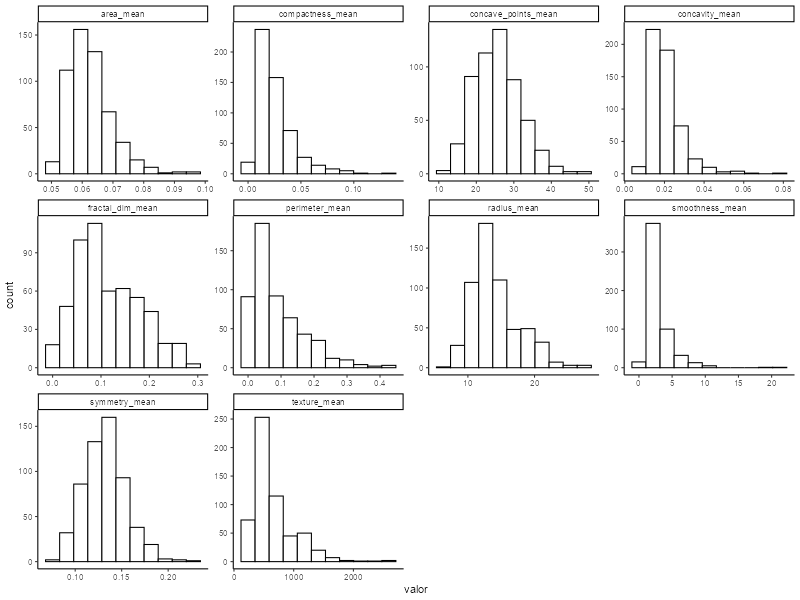

In [141]:
dados_longos %>%
  dplyr::filter(variavel %>% grepl("_mean", x = .)) %>%
  ggplot() +
  geom_histogram(
    aes(x = valor), # , color = diagnosis, alpha = 0.75),
    bins = nclass.Sturges(dados$radius_mean),
    color = "black", fill = "white"
    # fill = "white"
  ) + # critério de sturges
  facet_wrap(~variavel, scales = "free") + # primeiro sem e depois com `scales = "free"`
  theme_classic()

Warning message:
Removed 196 rows containing non-finite outside the scale range
(`stat_boxplot()`). 


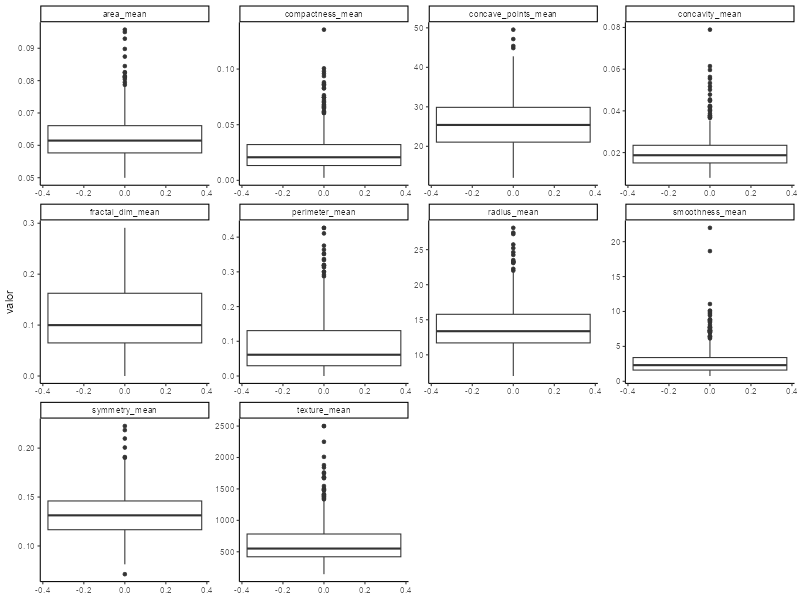

In [107]:
dados_longos %>%
  dplyr::filter(variavel %>% grepl("_mean", x = .)) %>%
  ggplot() +
  geom_boxplot(aes(y = valor)) + # primeico com `x = valor`, depois `y = valor`
  facet_wrap(~variavel, scales = "free") +
  theme_classic()

Warning message:
Removed 196 rows containing non-finite outside the scale range
(`stat_boxplot()`). 


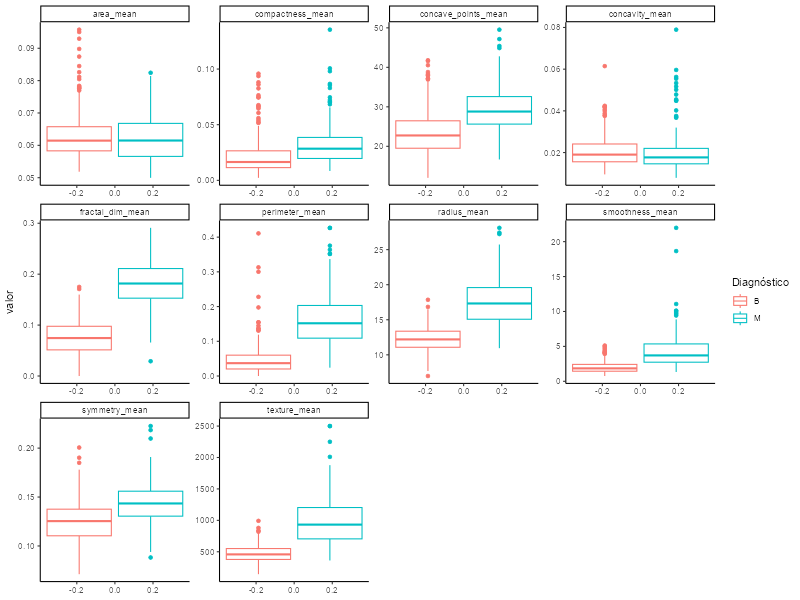

In [ ]:
dados_longos %>%
  dplyr::group_by(diagnosis) %>%
  dplyr::filter(variavel %>% grepl("_mean", x = .)) %>%
  ggplot() +
  geom_boxplot(aes(y = valor, color = diagnosis)) + # exercício, refaçam os histogramas separando por grupo
  # geom_violin(aes(y = valor, x = diagnosis, color = diagnosis)) + # apresentar plot de violino
  facet_wrap(~variavel, scales = "free") +
  labs(color = "Diagnóstico") + # primeiro sem `color`, depois `title` e `subtitle`
  theme_classic()

Warning messages:
1: Removed 28 rows containing non-finite outside the scale range
(`stat_boxplot()`). 
2: In ggally_statistic(data = data, mapping = mapping, na.rm = na.rm,  :
  Removed 28 rows containing missing values
3: In ggally_statistic(data = data, mapping = mapping, na.rm = na.rm,  :
  Removed 28 rows containing missing values
4: Removed 28 rows containing non-finite outside the scale range (`stat_bin()`). 
5: Removed 28 rows containing missing values or values outside the scale range
(`geom_point()`). 
6: Removed 28 rows containing missing values or values outside the scale range
(`geom_point()`). 
7: Removed 28 rows containing non-finite outside the scale range
(`stat_density()`). 


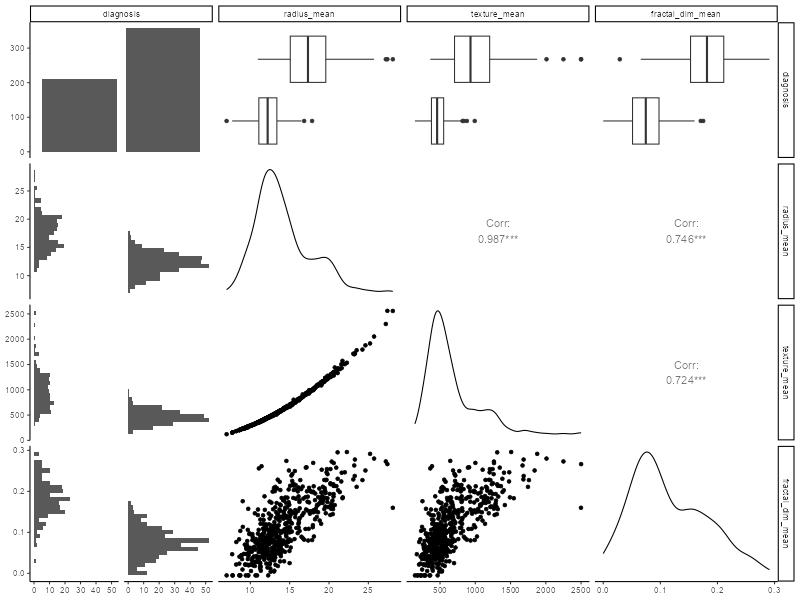

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [217]:
dados %>%
  dplyr::select(diagnosis, radius_mean, texture_mean, fractal_dim_mean) %>%
  GGally::ggpairs(
    # upper = list(continuous = wrap(ggally_cor, method = "spearman")) # para correlação não paramétrica
  ) +
  theme_classic()

Warning messages:
1: Removed 28 rows containing non-finite outside the scale range
(`stat_boxplot()`). 
2: In ggally_statistic(data = data, mapping = mapping, na.rm = na.rm,  :
  Removed 28 rows containing missing values
3: In ggally_statistic(data = data, mapping = mapping, na.rm = na.rm,  :
  Removed 28 rows containing missing values
4: Removed 28 rows containing non-finite outside the scale range (`stat_bin()`). 
5: Removed 28 rows containing missing values or values outside the scale range
(`geom_point()`). 
6: Removed 28 rows containing missing values or values outside the scale range
(`geom_point()`). 
7: Removed 28 rows containing non-finite outside the scale range
(`stat_density()`). 


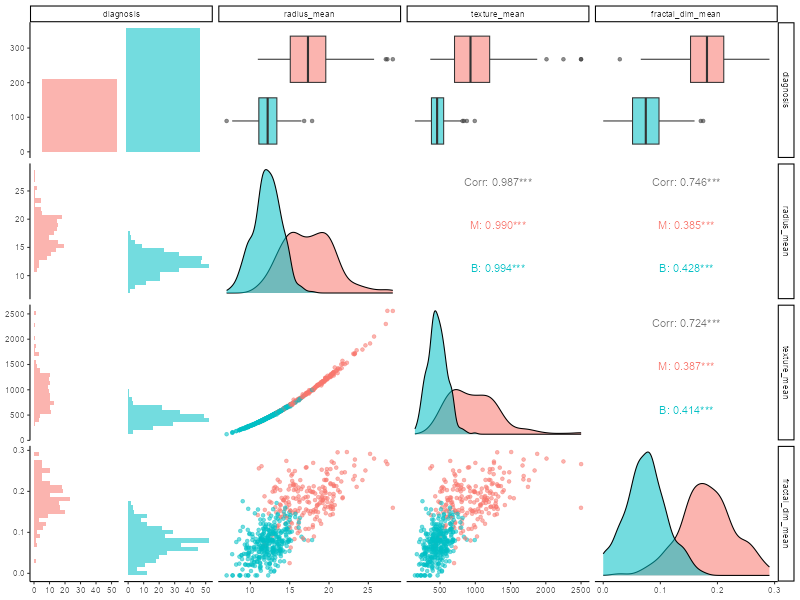

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [219]:
# comentar sobre análise de agrupamentos
dados %>%
  dplyr::select(diagnosis, radius_mean, texture_mean, fractal_dim_mean) %>%
  GGally::ggpairs(
    aes(color = diagnosis, alpha = 0.5),
    # upper = list(continuous = wrap(ggally_cor, method = "spearman")) # para correlação não paramétrica
  ) +
  theme_classic()

In [92]:
# exemplo para apresentar a correlação de Spearman
corrr::correlate(dados, method = "spearman") %>%
  dplyr::filter(term == "radius_mean") %>%
  dplyr::select(texture_mean)

Non-numeric variables removed from input: `diagnosis`
Correlation computed with
• Method: 'spearman'
• Missing treated using: 'pairwise.complete.obs'


# A tibble: 1 × 1
  texture_mean
         <dbl>
1        1.000

Agora árvores de decisão. Usaremos as funções `initial_split`, `training` e `testing` do pacote *TidyModels* para dividir nosssos dados em subconjuntos de treinamento e validação.

In [169]:
set.seed(20251125)
split <- rsample::initial_split(dados, prop = 0.8)
treino <- rsample::training(split)
teste <- rsample::testing(split)

In [208]:
tree_spec <- parsnip::decision_tree(
  mode = "classification",
  engine = "rpart",
  tree_depth = 4
)

tree_fit <- tree_spec %>%
  fit(diagnosis ~ ., data = treino)

In [209]:
predicoes <- tree_fit %>%
  predict(teste) %>%
  dplyr::pull(.pred_class)

Matriz de confusão

In [210]:
teste %>%
  dplyr::mutate(predicoes = predicoes) %>%
  conf_mat(truth = diagnosis, estimate = predicoes)

          Truth
Prediction  M  B
         M 37  2
         B  7 68

Métricas de acurácia

In [211]:
metricas <- metric_set(accuracy, kap) # acuracia e \kappa
desempenho <- teste %>%
  dplyr::mutate(predicoes = predicoes) %>%
  metricas(truth = diagnosis, estimate = predicoes)

print(desempenho)

# A tibble: 2 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.921
2 kap      binary         0.830


Com o seguinte gráfico, podemos interpretar o modelo.

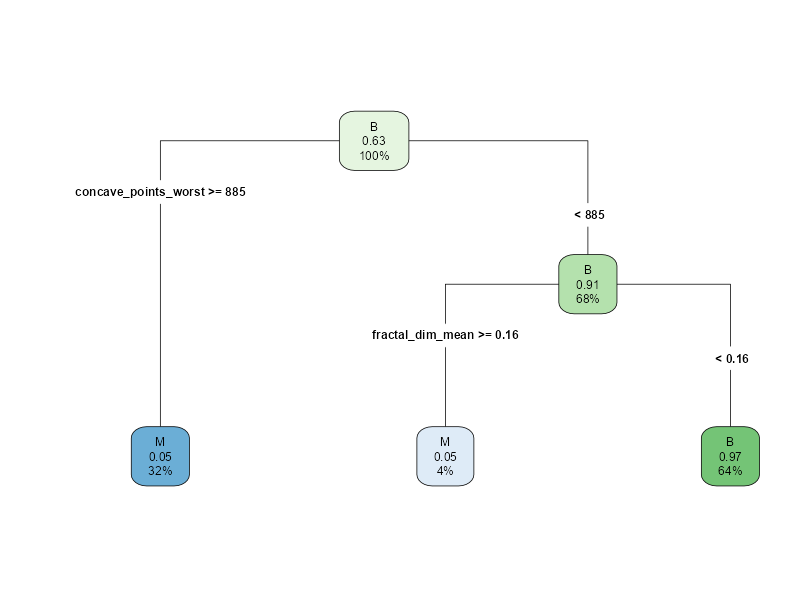

In [212]:
rpart.plot::rpart.plot(tree_fit$fit, type = 4, roundint = FALSE)

In [220]:
dados %>% readr::write_csv("dados_tratados.csv")